# GUI Evaluation Notebook
This notebook evaluates generated GUI prototypes (in HTML) against original GUI images (in JPG) using quantitative metrics.
We focus on similarity, visual layout comparison, and DOM complexity analysis.

In [16]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from html2image import Html2Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Configuration
Paths and evaluation settings.

In [3]:
original_path = "rico_guis"
generated_path = "generated_guis"

prompt_types = ["CoT_fs", "CoT_zs", "instruction", "pd_fs", "pd_zs"]

# Metric Functions
We define metrics including:
- **SSIM** for visual similarity.
- **DOM Complexity** via tag count.
- **Layout Area** by summing element bounding boxes (via inline style parsing).


In [33]:
def render_html_to_image(html_path, output_image_path):
    try:
        hti = Html2Image(output_path=os.path.dirname(output_image_path))
        hti.screenshot(
            html_file=html_path,
            save_as=os.path.join(output_image_path),
            size=(800, 1280)  # width x height
        )
        return output_image_path
    except Exception as e:
        print(f"Rendering error {html_path}: {e}")
        return None

def compute_ssim(image1_path, image2_path):
    try:
        img1 = Image.open(image1_path).convert("L").resize((256, 256))
        img2 = Image.open(image2_path).convert("L").resize((256, 256))
        ssim_val = ssim(np.array(img1), np.array(img2))
        return ssim_val
    except Exception as e:
        print(f"Error comparing {image1_path} and {image2_path}: {e}")
        return np.nan

def compute_dom_complexity(html_path):
    try:
        with open(html_path, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f, "html.parser")
        return len(soup.find_all())
    except Exception as e:
        print(f"Error parsing {html_path}: {e}")
        return np.nan

def json_find_bounds(obj):
    bounds_list = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if k == "bounds":
                x = v[0]
                y = v[1]
                w = v[2]
                h = v[3]
                bounds_list.append((x, y, x + w, y + h))
            else:
                bounds_list.extend(json_find_bounds(v))
    elif isinstance(obj, list):
        for item in obj:
            bounds_list.extend(json_find_bounds(item))
    return bounds_list

def html_find_bounds(html_path):
    try:
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        driver = webdriver.Chrome(options=chrome_options)
        driver.set_window_size(1440, 2560)
        driver.get(f"C:\\Users\Marija\IdeaProjects\effective-gui-prototyping\\{html_path}")
        elements = driver.find_elements("css selector", "*")

        bounds_list = []
        for el in elements:
            rect = driver.execute_script("""
                var rect = arguments[0].getBoundingClientRect();
                return {left: rect.left, top: rect.top, width: rect.width, height: rect.height};
            """, el)
            if rect['width'] > 0 and rect['height'] > 0:
                x = rect["left"]
                y = rect["top"]
                w = rect["width"]
                h = rect["height"]
                bounds_list.append((x, y, x + w, y + h))

        driver.quit()
        return bounds_list

    except Exception as e:
        print(f"Error parsing {html_path}: {e}")
        return np.nan

def intersection_area(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x2 < x1 or y2 < y1:
        return 0
    return (x2 - x1) * (y2 - y1)

def extract_layout_area(json_path, html_path):
    if not os.path.exists(json_path):
        print(f"JSON does not exist {json_path}")
        return 0.0
    # try:
    #     with open(html_path, "r", encoding="utf-8") as f:
    #         html_elements = BeautifulSoup(f, "html.parser")
    # except Exception as e:
    #     print(f"Error parsing {html_path}: {e}")
    #     return np.nan

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        original_boxes = []
        bounds = json_find_bounds(data)
        original_boxes.extend(bounds)

        generated_boxes = html_find_bounds(html_path)

        if not original_boxes or not generated_boxes:
            return 0.0

        total_intersection = 0
        total_area = sum((b[2] - b[0]) * (b[3] - b[1]) for b in original_boxes)

        for obox in original_boxes:
            for gbox in generated_boxes:
                total_intersection += intersection_area(obox, gbox)

        return total_intersection / total_area if total_area > 0 else 0.0

    except Exception as e:
        print(f"Error parsing {json_path}: {e}")
        return 0.0

# Run Evaluation
Iterate through all GUI samples and compute metrics.

In [34]:
results = []

for gui_id in os.listdir(original_path):
    if not gui_id.endswith(".jpg"):
        continue
    gui_num = gui_id.split(".")[0]
    original_img_path = os.path.join(original_path, gui_id)
    original_json_path = os.path.join(original_path, f"{gui_num}.json")

    for prompt in prompt_types:
        html_path = os.path.join(generated_path, gui_num, f"{prompt}.html")
        html_img_path = f"{prompt}.png"

        dom_complexity = compute_dom_complexity(html_path)
        layout_area = extract_layout_area(original_json_path, html_path)
        rendered_img_path = render_html_to_image(html_path, html_img_path)
        ssim_score = compute_ssim(original_img_path, rendered_img_path)

        results.append({
            "GUI_ID": gui_num,
            "Prompt": prompt,
            "DOM_Complexity": dom_complexity,
            "Layout_Area": layout_area,
            "SSIM_Score": ssim_score
        })

df = pd.DataFrame(results)
df.head()

,GUI_ID,Prompt,DOM_Complexity,Layout_Area,SSIM_Score
0,1264,CoT_fs,24,0.071340,0.526207
1,1264,CoT_zs,23,0.080584,0.045800
2,1264,instruction,18,0.691916,0.580272
3,1264,pd_fs,31,0.189677,0.506057
4,1264,pd_zs,42,0.182940,0.422558


# Visualize Metrics

<Figure size 1200x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

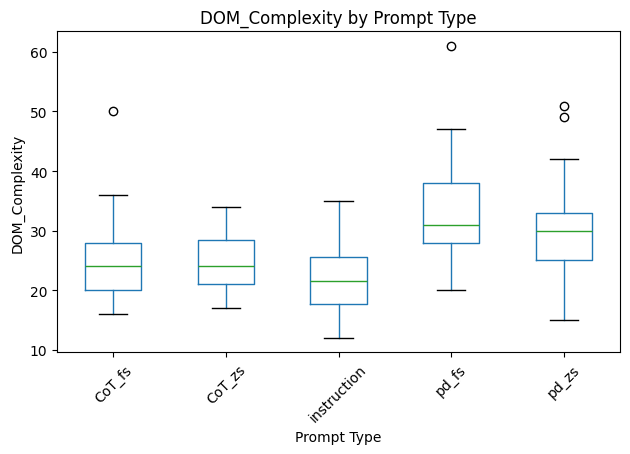

<Figure size 640x480 with 0 Axes>

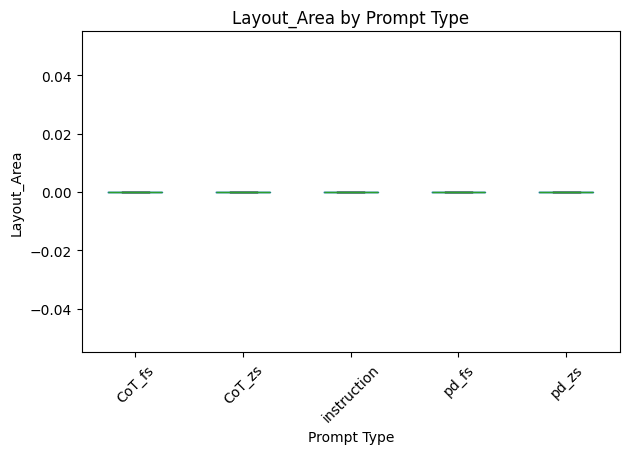

In [6]:
plt.figure(figsize=(12, 6))
for metric in ["DOM_Complexity", "Layout_Area"]:
    plt.figure()
    df.boxplot(column=metric, by="Prompt", grid=False)
    plt.title(f"{metric} by Prompt Type")
    plt.suptitle("")
    plt.ylabel(metric)
    plt.xlabel("Prompt Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Summary Table

In [7]:
summary = df.groupby("Prompt")[["DOM_Complexity", "Layout_Area"]].mean().round(1)
summary

,DOM_Complexity,Layout_Area
Prompt,,
CoT_fs,25.7,0.0
CoT_zs,24.7,0.0
instruction,21.9,0.0
pd_fs,32.9,0.0
pd_zs,30.6,0.0
